In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import datetime

from scipy.cluster.vq import kmeans,vq
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc_file
#rc_file('/home/p0friedr/okamp/Programme/Python/plotting/plotstyle.rc') 
from sklearn.cluster import KMeans

import argparse
from os import path
import pandas as pd
import time

## Get Correlation Data

In [2]:
# Companies' Normalised Returns Data
DF = pd.read_csv("Companies1992_2012.csv", index_col = "Date")
len(DF)

5291

In [3]:
DFnp = DF.to_numpy()
DFcorr = DF.corr()

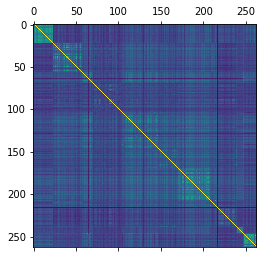

In [4]:
plt.matshow(DFcorr)
plt.show()

#### But first, only for the GICS sectors

In [5]:
DFSectors = pd.read_csv("NormalisedReturnsSector.csv", index_col = "Date")
print(DFSectors)

            Utilities  Information Technology  Materials  Health Care  \
Date                                                                    
1992-01-02        NaN                     NaN        NaN          NaN   
1992-01-03        NaN                     NaN        NaN          NaN   
1992-01-06        NaN                     NaN        NaN          NaN   
1992-01-07        NaN                     NaN        NaN          NaN   
1992-01-08        NaN                     NaN        NaN          NaN   
...               ...                     ...        ...          ...   
2012-12-24 -13.150235              -15.559262   3.114686   -10.961609   
2012-12-26 -30.880331              -26.606141  -3.296699   -34.500741   
2012-12-27  -4.516366               -7.459821  -9.782953    -0.294040   
2012-12-28 -24.800785              -33.630637 -20.600914   -36.070073   
2012-12-31  41.969551               49.739138  17.719807    46.563195   

            Industrials  Consumer Discretionary  F

In [6]:
# Get Sector Data from Wikipedia
payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
second_table = payload[1]

df = first_table
#show unique economy sectors
sectors = df['GICS Sector'].values.tolist()
sectors = set(sectors)

In [7]:
print(df)
df.to_csv("Sectors.csv")

    Symbol             Security SEC filings             GICS Sector  \
0      MMM                   3M     reports             Industrials   
1      ABT  Abbott Laboratories     reports             Health Care   
2     ABBV               AbbVie     reports             Health Care   
3     ABMD              Abiomed     reports             Health Care   
4      ACN            Accenture     reports  Information Technology   
..     ...                  ...         ...                     ...   
500    YUM          Yum! Brands     reports  Consumer Discretionary   
501   ZBRA   Zebra Technologies     reports  Information Technology   
502    ZBH        Zimmer Biomet     reports             Health Care   
503   ZION        Zions Bancorp     reports              Financials   
504    ZTS               Zoetis     reports             Health Care   

                      GICS Sub-Industry    Headquarters Location  \
0              Industrial Conglomerates    Saint Paul, Minnesota   
1          

In [8]:
# overlapping intervals
Period = 40 # 2 trading months
Shift = 10
T = int((len(DFSectors) - Period)/Shift)


# because of symmetry and diagonal of 1, only need upper triangle:
Index = np.triu(np.ones((11,11)),1)
print(Index.shape)
print(np.sum(Index))

Index = Index.reshape(1,-1)
Index = Index.astype(bool)
print(Index.shape, np.sum(Index))
CorrMatrices = np.empty((T, np.sum(Index)))


print(len(Index))

for t in range(T):
    #print((0+t*Shift),(Period+t*Shift))
    IntervalDF = DFSectors.iloc[(0+t*Shift):(Period+t*Shift)]
    IntervalCorr = IntervalDF.corr()
    IntervalCorr = IntervalCorr.to_numpy().reshape(1,-1)

    # Only save the non-trivial and unique elements of the correlation matrix
    CorrMatrices[t,:] = IntervalCorr[Index]
    

(11, 11)
55.0
(1, 121) 55
1


In [9]:
print(CorrMatrices.shape)
print(CorrMatrices)

(525, 55)
[[0.52101497 0.3186915  0.58230014 ... 0.24297144 0.21018616 0.12275564]
 [0.57937824 0.22839803 0.58069107 ... 0.21111546 0.16906246 0.04357593]
 [0.5295678  0.28518921 0.5138582  ... 0.17858937 0.16637894 0.16522966]
 ...
 [0.22186374 0.33573368 0.33164044 ... 0.33647531 0.6253862  0.25173392]
 [0.35544748 0.40885901 0.43552588 ... 0.55314313 0.76107342 0.27113554]
 [0.29443509 0.31598189 0.34930619 ... 0.54671925 0.85280403 0.32586505]]


525


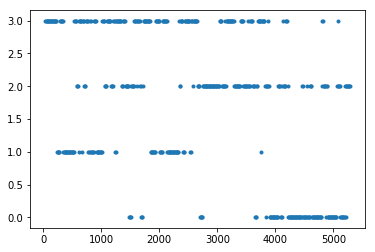

In [10]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(CorrMatrices)
ClusterPred = kmeans.fit_predict(CorrMatrices)
print(len(ClusterPred))
plt.scatter(np.arange(Period+1, len(DFSectors.index)-Shift, Shift), # DFSectors.index[np.arange(Period+1, len(DFSectors.index)-Shift, Shift)],
            ClusterPred, marker=".")
plt.show()

In [11]:
DFSectors.index

Index(['1992-01-02', '1992-01-03', '1992-01-06', '1992-01-07', '1992-01-08',
       '1992-01-09', '1992-01-10', '1992-01-13', '1992-01-14', '1992-01-15',
       ...
       '2012-12-17', '2012-12-18', '2012-12-19', '2012-12-20', '2012-12-21',
       '2012-12-24', '2012-12-26', '2012-12-27', '2012-12-28', '2012-12-31'],
      dtype='object', name='Date', length=5292)

### Now with the full data matrix


In [12]:
DFSectors.shape[1]

11

In [13]:
# overlapping intervals
Period = 40 # 2 trading months
Shift = 10
T = int((len(DF) - Period)/Shift)


# because of symmetry and diagonal of 1, only need upper triangle:
Index = np.triu(np.ones((DF.shape[1],DF.shape[1])),1)
print(Index.shape)
print(np.sum(Index))

Index = Index.reshape(1,-1)
Index = Index.astype(bool)
print(Index.shape, np.sum(Index))
CorrMatrices = np.empty((T, np.sum(Index)))


print(len(Index))

(263, 263)
34453.0
(1, 69169) 34453
1


In [14]:
for t in range(T):
    #print((0+t*Shift),(Period+t*Shift))
    IntervalDF = DF.iloc[(0+t*Shift):(Period+t*Shift)]
    IntervalCorr = IntervalDF.corr()
    IntervalCorr = IntervalCorr.to_numpy().reshape(1,-1)

    # Only save the non-trivial and unique elements of the correlation matrix
    CorrMatrices[t,:] = IntervalCorr[Index]
    

525


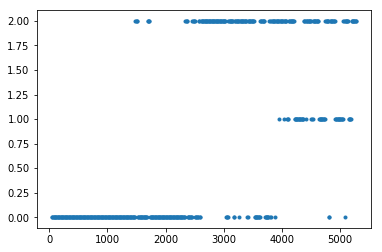

In [15]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(CorrMatrices)
ClusterPred = kmeans.fit_predict(CorrMatrices)
print(len(ClusterPred))
plt.scatter(np.arange(Period+1, len(DFSectors.index)-Shift, Shift), # DFSectors.index[np.arange(Period+1, len(DFSectors.index)-Shift, Shift)],
            ClusterPred, marker=".")
plt.show()

## Hutts Code

In [26]:
data = CorrMatrices

maxR = 10

  
dim=data.shape[1]
nt = data.shape[0]
vdim = int(np.sqrt(dim))

sum =np.zeros(nt)
distAll = []
AikAll = []
W = np.zeros(nt)


In [27]:
from scipy.cluster.vq import kmeans,vq

for ncluster in range(2,maxR+1):

    dist = np.zeros((ncluster,nt))
    # computing K-Means with K = 1,..., R (max. R clusters) 
    centroids,_ = kmeans(data,ncluster, seed = 12345)

    # assign each sample to a cluster
    idx,_ = vq(data,centroids)
    
    print('centroid: ', centroids.shape)
    #name = "dist"+str(ncluster)
    for i in range(0,ncluster):
        np.save("cluster_"+str(ncluster)+"_"+str(i),centroids[i])
        dist[i,:]=np.sqrt(np.sum((data[:]-centroids[i])**2,1))
    np.save("distances", dist)
    distAll.append(dist)

    Aik = np.zeros(nt)
    for i in range(0,nt):
        a = dist[:,i]                                                              
        Aik[i] = np.min(a[np.where(a!=np.min(a))]) - np.min(a)
      #           zweitnächster Nachbar           nächster Nachbar
    W = np.zeros(nt)  
    A=np.zeros(ncluster)  
    for i in range(0,ncluster):  
        A[i]=np.sum(Aik[np.where(idx==i)[0]])  
        W[np.where(idx==i)[0]]=A[i]

    N = np.sum(A)
    #plt.plot(W/N)

    max= np.max(dist)  
    sum = sum + W/N
    if ncluster == maxR:
        np.save("dist",dist)


centroid:  (2, 34453)
centroid:  (3, 34453)
centroid:  (4, 34453)
centroid:  (5, 34453)
centroid:  (6, 34453)
centroid:  (7, 34453)
centroid:  (8, 34453)
centroid:  (9, 34453)
centroid:  (10, 34453)


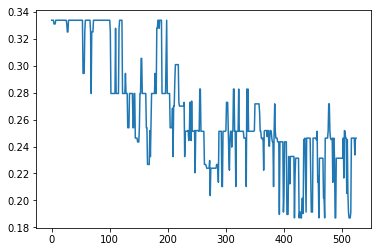

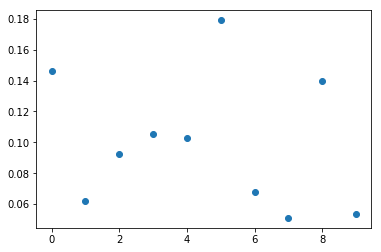

In [28]:
    
plt.figure("sum")
plt.plot(sum/(maxR-2))

plt.figure("Ai")
plt.plot(A/np.sum(A),"o")

#np.save("Gti",sum/(1.0*maxR))


## Now with a different seed


In [29]:

sum =np.zeros(nt)
distAll = []
AikAll = []
W = np.zeros(nt)


In [30]:
from scipy.cluster.vq import kmeans,vq

for ncluster in range(2,maxR+1):

    dist = np.zeros((ncluster,nt))
    # computing K-Means with K = 1,..., R (max. R clusters) 
    centroids,_ = kmeans(data,ncluster, seed = 54321)

    # assign each sample to a cluster
    idx,_ = vq(data,centroids)
    
    print('centroid: ', centroids.shape)
    #name = "dist"+str(ncluster)
    for i in range(0,ncluster):
        np.save("cluster_"+str(ncluster)+"_"+str(i),centroids[i])
        dist[i,:]=np.sqrt(np.sum((data[:]-centroids[i])**2,1))
    np.save("distances", dist)
    distAll.append(dist)

    Aik = np.zeros(nt)
    for i in range(0,nt):
        a = dist[:,i]                                                              
        Aik[i] = np.min(a[np.where(a!=np.min(a))]) - np.min(a)
      #           zweitnächster Nachbar           nächster Nachbar
    W = np.zeros(nt)  
    A=np.zeros(ncluster)  
    for i in range(0,ncluster):  
        A[i]=np.sum(Aik[np.where(idx==i)[0]])  
        W[np.where(idx==i)[0]]=A[i]

    N = np.sum(A)
    #plt.plot(W/N)

    max= np.max(dist)  
    sum = sum + W/N
    if ncluster == maxR:
        np.save("dist",dist)


centroid:  (2, 34453)
centroid:  (3, 34453)
centroid:  (4, 34453)
centroid:  (5, 34453)
centroid:  (6, 34453)
centroid:  (7, 34453)
centroid:  (8, 34453)
centroid:  (9, 34453)
centroid:  (10, 34453)


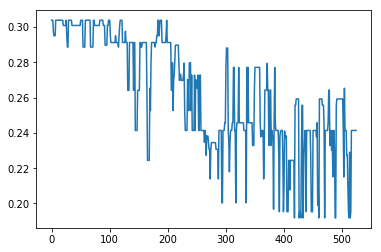

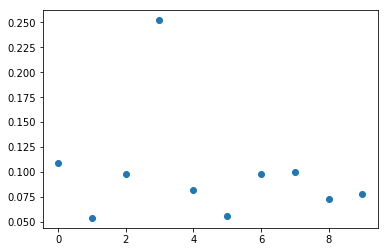

In [31]:

plt.figure("sum")
plt.plot(sum/(maxR-2))

plt.figure("Ai")
plt.plot(A/np.sum(A),"o")

#np.save("Gti",sum/(1.0*maxR))


This does not seem to show results that can be aligned with each other.

Maybe one has to subtract the first PCA like in Guhr's latest paper?

# Synthetic Example

In [19]:
T = 1000
p = 2 # dimensions

Data = np.zeros((T,p))
Data[0:500,:] = np.random.normal(0, 0.1, (500,p))
Data[500:,:] = np.random.normal(10, 0.1, (500,p))

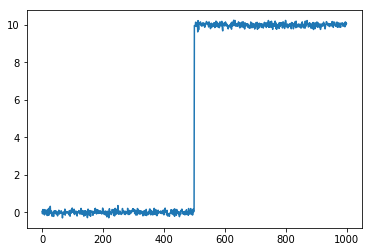

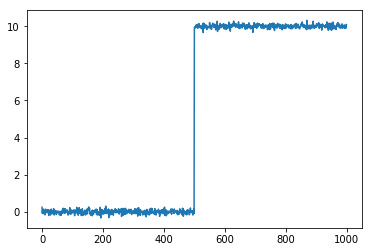

In [20]:
for i in range(2):
    plt.plot(Data[:,i])
    plt.show()

In [21]:
data = Data

In [22]:

maxR = 10

  
dim=data.shape[1]
nt = data.shape[0]
vdim = int(np.sqrt(dim))

sum =np.zeros(nt)
distAll = []
AikAll = []
W = np.zeros(nt)


In [23]:

for ncluster in range(2,maxR+1):

    dist = np.zeros((ncluster,nt))
    # computing K-Means with K = 1,..., R (max. R clusters) 
    centroids,_ = kmeans(data,ncluster)

    # assign each sample to a cluster
    idx,_ = vq(data,centroids)
    
    print('centroid: ', centroids.shape)
    #name = "dist"+str(ncluster)
    for i in range(0,ncluster):
        np.save("cluster_"+str(ncluster)+"_"+str(i),centroids[i])
        dist[i,:]=np.sqrt(np.sum((data[:]-centroids[i])**2,1))
    np.save("distances", dist)
    distAll.append(dist)

    Aik = np.zeros(nt)
    for i in range(0,nt):
        a = dist[:,i]                                                              
        Aik[i] = np.min(a[np.where(a!=np.min(a))]) - np.min(a)
      #           zweitnächster Nachbar           nächster Nachbar
    W = np.zeros(nt)  
    A=np.zeros(ncluster)  
    for i in range(0,ncluster):  
        A[i]=np.sum(Aik[np.where(idx==i)[0]])  
        W[np.where(idx==i)[0]]=A[i]

    N = np.sum(A)
    #plt.plot(W/N)

    max= np.max(dist)  
    sum = sum + W/N
    if ncluster == maxR:
        np.save("dist",dist)


centroid:  (2, 2)
centroid:  (3, 2)
centroid:  (4, 2)
centroid:  (5, 2)
centroid:  (6, 2)
centroid:  (7, 2)
centroid:  (8, 2)
centroid:  (9, 2)
centroid:  (10, 2)


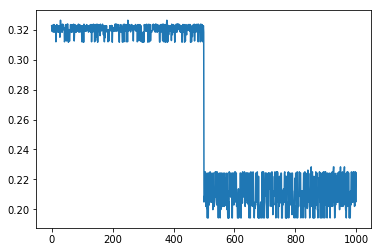

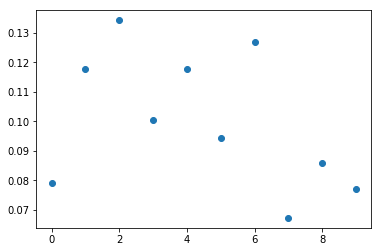

In [24]:
    
plt.figure("sum")
plt.plot(sum/(maxR-2))

plt.figure("Ai")
plt.plot(A/np.sum(A),"o")

#np.save("Gti",sum/(1.0*maxR))


Apparently, the high value for 2 in the second plot here means that there are two clusters? So high value in 2nd plot for k means that there are k clusters?